## CET 182 Introduction to Data Mining
Assignment

Student Name: Cheong Zihao, Daniel \
Matriculation ID: 

### Data Pre-processing

In [1]:
import os; import seaborn as sns; import pandas as pd; import numpy as np;
from ucimlrepo import fetch_ucirepo; from sklearn.preprocessing import OneHotEncoder;
import matplotlib.pyplot as plt; from sklearn.preprocessing import OrdinalEncoder;
from scipy.stats import spearmanr; import session_info
os.chdir('C:\\Users\\dc\\Desktop\\CET 182\\Project') # This is our working directory

In [2]:
# fetch dataset (Code copied from: https://archive.ics.uci.edu/dataset/2/adult)
adult = fetch_ucirepo(id=2) 
    # If 'ConnectionError' use Manual download 'Adult' dataset 
X = adult.data.features; y = adult.data.targets 
df = pd.DataFrame(data = adult.data.features)
df['target'] = y # add the target variable
df=df.set_index(pd.Series(range(1,df.shape[0]+1)))

In [3]:
# If url fails, run this code block.
#====================================
# Use downloaded text data in 2 files (adult.data.txt and adult.test.txt).
#original_train = pd.read_csv('adult.data.txt',sep=",",header=None)
#original_test = pd.read_csv('adult.test.txt',sep=",",header=None)
#df = pd.concat([original_train,original_test])
#df=df.set_index(pd.Series(range(1,df.shape[0]+1)))
#url_training = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
#url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

#features = ['age','workclass','fnlwgt','education','education-num', 'marital-status','occupation',
#           'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','target']
#df.columns = features
#df=df.set_index(pd.Series(range(1,df.shape[0]+1)))

In [4]:
print("shape of data in (rows, columns) is " + str(df.shape)); # df.tail()

shape of data in (rows, columns) is (48842, 15)


In [5]:
# Our first preprocessing step is to remove duplicate rows.
df.drop_duplicates(inplace=True); df.shape[0]

48813

In [6]:
print(df['target'].unique())

['<=50K' '>50K' '<=50K.' '>50K.']


In [7]:
def cleaning_target(row):
    if row == '<=50K': target = 0
    elif row == '<=50K.':target=0
    elif row == '>50K': target = 1
    else: target = 1 # row == '>50K.'
    return target
df['target'] = df['target'].apply(cleaning_target)

In [8]:
df['target'].value_counts(normalize=True).to_frame()

,target
0,0.760617
1,0.239383


In [9]:
total_null = df.isnull().sum().sum()
total_data_pts=(df.shape[0])*(df.shape[1])
if (((total_null/total_data_pts)*100) < 1):  
    df = df.dropna(axis='rows') # missing data <1%, drop the rows.
print(df.shape)

(47592, 15)


##### Dealing with other Missing values: The UCI Machine Learning site mentioned 3 such variables. The metadeta description mentioned that native-country is '?' if unknown. 
##### '?' may be in the other variables as well. Lets create a subset of the missing data.

In [10]:
rows_missing = df[ (df['workclass'] == '?') | (df['native-country'] == '?') | (df['occupation'] == '?') ]
print("Percentage of rows with '?' values :{0:f}".format(rows_missing.shape[0]/df.shape[0]*100) )

Percentage of rows with '?' values :5.038662


In [11]:
rows_missing.shape[0]

2398

In [12]:
# Lets drop these rows since a large number of the data (>94%) is still retained.
df=df[(df['workclass'] != '?') & (df['native-country'] != '?') & (df['occupation'] != '?')]

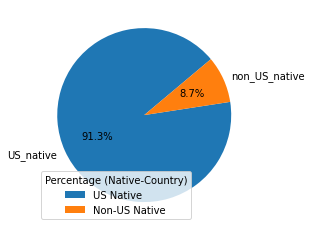

In [13]:
# Consider if 'native-country' attribute can be dropped
df['US_native'] = np.where(df['native-country'] == "United-States", 1, 0)
pie_data = df['US_native'].value_counts()/(df['US_native'].value_counts().sum())*100
mylabels = ["US_native", "non_US_native"]
plt.pie(pie_data, labels = mylabels, startangle = 40, autopct='%1.1f%%')
plt.legend(title='Percentage (Native-Country)',labels=['US Native','Non-US Native'],loc='best')
plt.show()


In [14]:
df= df.drop(columns= ['native-country','US_native'])

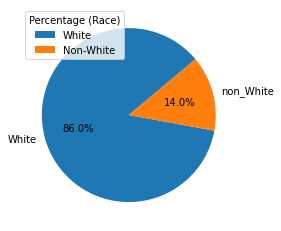

In [15]:
# Similarly, majority of race is white. 
df['race2'] = np.where(df['race'] == "White", 1, 0)
pie_data = df['race2'].value_counts()/(df['race2'].value_counts().sum())*100
mylabels = ["White", "non_White"]
plt.pie(pie_data, labels = mylabels, startangle = 40, autopct='%1.1f%%')
plt.legend(title='Percentage (Race)',labels=['White','Non-White'],loc='best')
plt.savefig("race.jpg")
plt.show()

In [16]:
df= df.drop(columns= ['race','race2'])

In [17]:
# Subjects who do not work ('workclass' is without pay or never worked) should be removed from model training
# as it is not expected they will have an income.
df = df[(df['workclass'] != 'Without-pay') & (df['workclass'] != 'Never-worked')]; df.shape

(45173, 13)

In [18]:
# It is not feasible that a person works >12hrs daily (>84hrs/week)--> drop these from analysis.
df = df[df['hours-per-week'] <= 84]

In [19]:
# 'education' can be dropped as well, as it is highly correlated to 'education-num'.
edu_num_array = np.array(df['education-num'])
edu_array = np.array(df['education'])
edu_enc = OrdinalEncoder(categories=[['Preschool','1st-4th','5th-6th', '7th-8th', '9th','10th', '11th','12th','HS-grad',
                                  'Some-college','Assoc-voc','Assoc-acdm','Bachelors','Masters','Prof-school','Doctorate']])
edu_encoded = edu_enc.fit_transform(edu_array.reshape(-1,1)) 
spearmanr(edu_encoded, edu_num_array)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [20]:
df = df.drop(columns = ['education'])

# Creating dummy variables for each categorical variable
#one_hot_enc = OneHotEncoder(handle_unknown='ignore') # from sklearn.preprocessing module
def label_encode_func(series):
    ds2=pd.DataFrame()
    ds2=pd.get_dummies(series,prefix=series.name,prefix_sep='_')
    return ds2

do=pd.DataFrame()
for i in range(df.shape[1]):
    if df[df.columns[i]].dtype =='object':
        ds1=label_encode_func(df[df.columns[i]])
        do=pd.concat([do,ds1], sort=False, axis='columns', join = 'outer')

In [21]:
df = pd.concat([df,do], sort=False, axis='columns', join = 'outer')

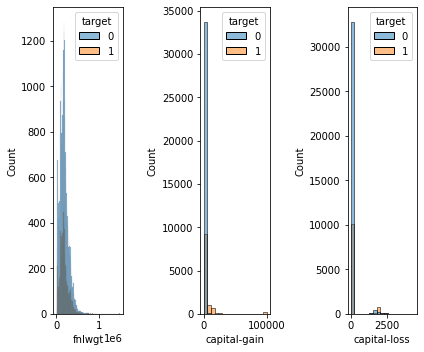

In [22]:
# Check if other numeric variables can be dropped 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(6,5))
sns.histplot(data=df, x='fnlwgt', hue='target', ax=ax1)
sns.histplot(data=df, x='capital-gain', hue='target', ax=ax2)
sns.histplot(data=df, x='capital-loss', hue='target', ax=ax3)
fig.tight_layout()
plt.show()

##### Insight - fnlwgt, capital-gain, capital-loss seemed not well differentiated by target. Many of them are 0 values. These variables are less helpful for model training.

In [23]:
# Preprocessing - Standardize 'age','hours-per-week','education-num' (mean 0, variance 1)
df=df.assign(age_scaled=lambda x:(x['age'] - x['age'].mean())/x['age'].std(),
          hpw_scaled=lambda x:(x['hours-per-week'] - x['hours-per-week'].mean())/x['hours-per-week'].std(),
          education_scaled=lambda x:(x['education-num'] - x['education-num'].mean())/x['education-num'].std())

In [24]:
print("Percentage of rows remaining from original dataset after pre-processing: {0:f}"\
      .format(df.shape[0]/len(X)*100))

Percentage of rows remaining from original dataset after pre-processing: 92.023259


### Training the model

##### The UCI ML Repository mentioned that support vector classification is among the top 5 models for baseline model performance (Best for Precision, 3rd best for Accuracy).
##### Precision score of SVC: 87.3 ~ 88.8, 
##### Accuracy score of SVC: 79.2 ~ 80.5

In [25]:
# Variable selection for Training the model
X = df.drop(columns=['target','age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'sex', 'capital-gain','capital-loss', 'hours-per-week'])
y = df['target']

In [26]:
X.head()

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,sex_Female,sex_Male,age_scaled,hpw_scaled,education_scaled
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0.035737,-0.058841,1.129579
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0.868263,-2.429632,1.129579
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,-0.039947,-0.058841,-0.438959
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1.095316,-0.058841,-1.223228
5,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,-0.796789,-0.058841,1.129579


In [27]:
from sklearn.model_selection import train_test_split

# Split the dataset (80-20)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Classification Task
# Support Vector Machine (B. Priya)
from sklearn import svm, metrics

svc = svm.LinearSVC(C=1)
svc.fit(X_train,y_train)

# Predict the labels for the test set
y_pred = svc.predict(X_test)

#accuracy = metrics.accuracy_score(y_test, y_pred)
#confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
#print(f"{accuracy=:.2f} and the confusion matrix is:")
#print(confusion_matrix)

C:\Users\dc\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [29]:
svc.get_params()

{'C': 1,
 'class_weight': None,
 'dual': 'warn',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [30]:
# Model performance
#------------------
accuracy = metrics.accuracy_score(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
precision_score = metrics.precision_score(y_test, y_pred)
print(f"{accuracy=:.2f} and the confusion matrix is:")
print(confusion_matrix)
print("The precision score of the model is: {0:f}".format(precision_score))

accuracy=0.83 and the confusion matrix is:
[[6224  530]
 [ 962 1274]]
The precision score of the model is: 0.706208


In [31]:
# Clustering Task
# KMeans clustering

In [32]:
X2 = df[['age_scaled','hpw_scaled','education_scaled']]
# Split the dataset (80-20)
X_train2, X_test2, y_train2, y_test2=train_test_split(X2, y, test_size=0.2, random_state=42)

In [33]:
# Classification task - To use a plot and determine the ideal number of clusters
# KMeans Algorithm with plot to determine ideal K
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html
from sklearn.cluster import KMeans

In [34]:
n_clusters = [2,3,4,5,6,7,8,9,10] 
for k in n_clusters:
    kmeans2 = KMeans(n_clusters=k,init='k-means++',n_init=10,random_state=42).fit(X_train2)
    cluster_labels = kmeans2.predict(X_test2)
    S = metrics.silhouette_score(X_test2, cluster_labels)
    print("n_clusters = {:d}, silhouette_score {:1f}".format(k,S))

n_clusters = 2, silhouette_score 0.246002
n_clusters = 3, silhouette_score 0.291999
n_clusters = 4, silhouette_score 0.312766
n_clusters = 5, silhouette_score 0.326650
n_clusters = 6, silhouette_score 0.336387
n_clusters = 7, silhouette_score 0.339104
n_clusters = 8, silhouette_score 0.337577
n_clusters = 9, silhouette_score 0.306396
n_clusters = 10, silhouette_score 0.315914


In [35]:
kmeans_final = KMeans(n_clusters=7,init='k-means++',n_init=10,random_state=42).fit(X_train2)

In [36]:
kmeans_final.cluster_centers_

array([[-0.67393043,  0.03215463, -0.3107357 ],
       [ 1.92276882, -1.86558339, -0.1018082 ],
       [ 0.0473853 ,  0.21465555,  1.27996721],
       [ 0.11763542,  1.97372851,  0.19655096],
       [ 0.96010148,  0.04745446, -0.21201064],
       [-1.15349353, -1.76277885, -0.25552617],
       [ 0.42517521, -0.04439356, -2.22198663]])

In [37]:
print(kmeans_final.inertia_)
print(kmeans_final.n_iter_)
print(kmeans_final.n_features_in_)

33773.54186246601
12
3


In [38]:
session_info.show()